In [1]:
import sagemaker
from sagemaker.local import LocalSession
from sagemaker.pytorch import PyTorch

In [2]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()

prefix = "sagemaker/pytorch_cifar100"
role = sagemaker.get_execution_role()

In [3]:
role

'arn:aws:iam::509765771925:role/service-role/AmazonSageMaker-ExecutionRole-20220126T162330'

In [4]:
pip install torchvision==0.5.0 --no-cache-dir

     |████████████████████████████████| 4.0 MB 12.1 MB/s            
     |██████████████████████▏         | 521.9 MB 91.5 MB/s eta 0:00:03 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 753.4 MB 77.6 MB/s             
Note: you may need to restart the kernel to use updated packages.


In [5]:
from torchvision import datasets, transforms, models
import torch.nn as nn

In [62]:
! rm -r data

In [ ]:
! pip install cifar2png
! cifar2png cifar100 data

In [65]:
inputs = sagemaker_session.upload_data(path='./data', bucket=bucket, key_prefix=prefix)
print(f"s3 path is @ {inputs}")

s3 path is @ s3://sagemaker-af-south-1-509765771925/sagemaker/pytorch_cifar100


In [6]:
inputs = 's3://sagemaker-af-south-1-509765771925/sagemaker/pytorch_cifar100'

In [70]:

estimator = PyTorch(
    entry_point='src/cifar.py', 
    dependencies=['src/requirements.txt'],
    role=role, 
    framework_version='1.8.0', 
    instance_count=1, 
    py_version='py3', 
    instance_type="ml.g4dn.2xlarge", 
    hyperparameters={"epochs": 1, "gpus": 1}
)

In [7]:
## gpu spot
estimator = PyTorch(
    entry_point='src/cifar.py', 
    dependencies=['src/requirements.txt'],
    role=role, 
    framework_version='1.8.0', 
    instance_count=1, 
    py_version='py3', 
    instance_type="ml.g4dn.12xlarge", 
    hyperparameters={"epochs": 4, "gpus": 4}, 
    use_spot_instances = True,
    max_run = 600,
    max_wait = 1200,
    checkpoints_s3_uri = "s3://sagemaker-af-south-1-509765771925/sagemaker/checkpoint"
)

In [9]:
## gpu spot
estimator = PyTorch(
    entry_point='src/cifar.py', 
    dependencies=['src/requirements.txt'],
    role=role, 
    framework_version='1.8.0', 
    instance_count=1, 
    py_version='py3', 
    instance_type="ml.g4dn.12xlarge", 
    hyperparameters={"epochs": 4, "gpus": 4}
)

In [10]:
estimator.fit({"train": inputs})

2022-02-04 14:15:39 Starting - Starting the training job...
2022-02-04 14:16:06 Starting - Preparing the instances for trainingProfilerReport-1643984139: InProgress
......
2022-02-04 14:17:04 Downloading - Downloading input data....................................
2022-02-04 14:23:05 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-04 14:23:04,533 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-04 14:23:04,575 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-04 14:23:04,581 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-04 14:23:04,870 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.6 -m pip install -r requirements.txt
  Created wheel for idna-ssl: filename=i

In [11]:
estimator.model_data

's3://sagemaker-af-south-1-509765771925/pytorch-training-2022-02-04-14-15-39-305/output/model.tar.gz'

In [12]:
predictor = estimator.deploy(
    initial_instance_count = 1, 
    instance_type="ml.m5.xlarge"
)

-----!

In [ ]:
! wget https://cdn.britannica.com/55/2155-050-604F5A4A/lion.jpg
! wget https://www.collinsdictionary.com/images/thumb/lobster_107132279_250.jpg

In [13]:
from PIL import Image
import numpy as np

In [14]:
str_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 
              'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 
              'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 
              'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 
              'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 
              'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 
              'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 
              'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 
              'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 
              'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 
              'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 
              'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 
              'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 
              'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 
              'wolf', 'woman', 'worm']

In [16]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

infer_transform = transforms.Compose([
                                    transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)
])

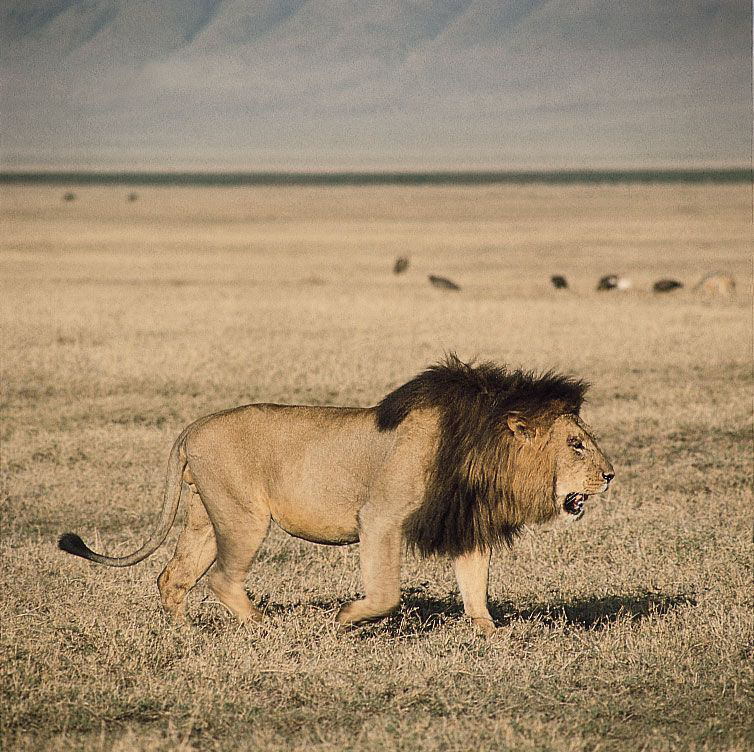

In [92]:
Image.open('lion.jpg')

In [20]:
lion = infer_transform(Image.open('lion.jpg'))
response = predictor.predict(np.expand_dims(lion, axis=0))
print(f"Prediction for image is -- {str_labels[np.argmax(response)]}")

Prediction for image is -- plain


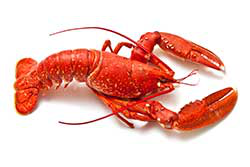

In [18]:
Image.open('lobster.jpg')

In [19]:
lobster = infer_transform(Image.open('lobster.jpg'))
response = predictor.predict(np.expand_dims(lobster, axis=0))
print(f"Prediction for image is -- {str_labels[np.argmax(response)]}")

Prediction for image is -- lobster
